In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt
import glob
import subprocess

import extract_features
import knn_cnn_features
import h5py
%matplotlib inline

In [2]:
def load_image(img_path, resize=True):
    tmp_img = imageio.imread(img_path)
    if resize:
        return transform.resize(image=tmp_img,output_shape=(200,200),anti_aliasing=True, mode='constant')
    return tmp_img

In [2]:
%timeit feature = extract_features.get_vector_resnet50('data/images/golden1.jpg')

20 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
%timeit feature = extract_features.get_vector_resnet18('data/images/golden1.jpg')

10.4 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Resnet 50** takes $2$ times the amount of time as **Resnet 18** i.e. $20$ms vs $10$ms.

In [3]:
classes = sorted([path.split("/")[-1] for path in glob.glob("data/videos/*")])
print(classes)

['animals', 'children', 'christmas', 'nature', 'school', 'snow', 'work']


In [2]:
feature = extract_features.get_vector_resnet50('data/images/golden1.jpg')

In [7]:
feature.shape

(2048,)

In [3]:
concat_features = np.repeat([feature], repeats=1000,axis=0)
concat_features.shape

(1000, 2048)

In [6]:
import knn_cnn_features
%time feature_indices = knn_cnn_features.run_knn_features(concat_features,k=3)

Number of records: 1000 
Number of dimensions: 2048
Running with Flat index for 1000 records of with dimensionality 2048
CPU times: user 9.75 ms, sys: 86.7 ms, total: 96.4 ms
Wall time: 94.9 ms


For $1000$ feature vectors of dimensionality $2048$, the KNN search is very fast i.e. around $90$ms. These indices for the feature vectors can be used to get the corresponding videos and thereby similarity search can be implemented.

## Extracting real features (UCF101)

In [2]:
videos = sorted(glob.glob("data/UCF101/*"))
ucf_classes = [vid.split('/')[-1].split('_')[1] for vid in videos]
ucf_classes = sorted(list(set(ucf_classes)))
print("There are",len(ucf_classes),"classes in UCF dataset")

There are 101 classes in UCF dataset


In [38]:
# get lengths of all videos
lengths = []
for vid in videos:
    length = !ffprobe -v error -select_streams v:0 -show_entries stream=duration -of \
        default=noprint_wrappers=1:nokey=1 $vid
    length = float(length[0])
    lengths.append(length)

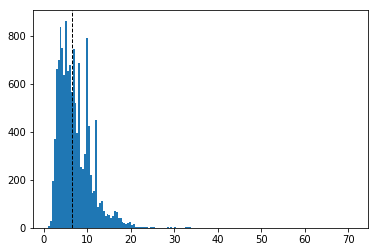

In [45]:
plt.hist(lengths, bins='auto')
plt.axvline(np.median(lengths), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [33]:
num_of_frames = 8 # Using 8 since UCF has a median video length of less than 8 second
def extract_features_from_vid(vid_path):
    p = subprocess.Popen("sh extractNFrames.sh "+vid_path+" "+str(num_of_frames), \
                         stdout=subprocess.PIPE, shell=True)
    p_status = p.wait()
    (output, err) = p.communicate()
    frame_list = glob.glob('data/tmp/*.jpg')
    vid_feature_vector = None
    for fr in frame_list:
        feature_vector = extract_features.get_vector_resnet50(fr)
        if type(vid_feature_vector) is not np.ndarray:
            vid_feature_vector = feature_vector
        else:
            vid_feature_vector = np.vstack((vid_feature_vector, feature_vector))
    return vid_feature_vector

In [40]:
h5f = h5py.File('features_UCF_resnet50.h5', 'w')

In [41]:
from tqdm import tqdm
for vid in tqdm(videos):
    test_vfv = extract_features_from_vid(vid)
    h5f.create_dataset(vid,  data=test_vfv)
h5f.close()


  2%|▏         | 297/13320 [01:07<48:19,  4.49it/s]


  4%|▍         | 593/13320 [02:14<45:02,  4.71it/s]


  7%|▋         | 889/13320 [03:20<41:19,  5.01it/s]


  9%|▉         | 1183/13320 [04:25<52:00,  3.89it/s]


 11%|█         | 1475/13320 [05:35<48:24,  4.08it/s]


 13%|█▎        | 1766/13320 [06:53<44:50,  4.29it/s]


 15%|█▌        | 2058/13320 [07:58<39:02,  4.81it/s]


 18%|█▊        | 2350/13320 [09:07<44:12,  4.14it/s]


 20%|█▉        | 2642/13320 [10:22<41:47,  4.26it/s]


 22%|██▏       | 2934/13320 [11:32<38:12,  4.53it/s]


 24%|██▍       | 3226/13320 [12:38<38:17,  4.39it/s]


 26%|██▋       | 3518/13320 [13:50<1:04:08,  2.55it/s]


 29%|██▊       | 3810/13320 [15:04<35:05,  4.52it/s]


 31%|███       | 4102/13320 [16:12<33:06,  4.64it/s]


 33%|███▎      | 4394/13320 [17:22<37:34,  3.96it/s]


 35%|███▌      | 4686/13320 [18:34<35:22,  4.07it/s]


 37%|███▋      | 4978/13320 [19:45<31:19,  4.44it/s]


 40%|███▉      | 5270/13320 [20:58<29:36,  4.53it/s]


 42%|████▏     | 5562/13320 [22:12<39:59,  3.23it/s]


 44%|████▍     | 5854/13320 [23:24<32:52,  3.78it/s]


 46%|████▌     | 6146/13320 [24:38<32:38,  3.66it/s]


 48%|████▊     | 6438/13320 [26:04<21:35,  5.31it/s]


 51%|█████     | 6730/13320 [27:31<26:24,  4.16it/s]


 53%|█████▎    | 7022/13320 [28:41<22:18,  4.71it/s]


 55%|█████▍    | 7314/13320 [29:52<24:55,  4.02it/s]


 57%|█████▋    | 7606/13320 [31:07<20:26,  4.66it/s]


 59%|█████▉    | 7898/13320 [32:24<30:59,  2.92it/s]


 61%|██████▏   | 8190/13320 [33:52<22:22,  3.82it/s]


 64%|██████▎   | 8482/13320 [35:17<22:18,  3.61it/s]


 66%|██████▌   | 8774/13320 [36:42<18:20,  4.13it/s]


 68%|██████▊   | 9066/13320 [37:57<17:36,  4.02it/s]


 70%|███████   | 9358/13320 [39:14<18:22,  3.59it/s]


 72%|███████▏  | 9650/13320 [40:27<13:05,  4.67it/s]


 75%|███████▍  | 9942/13320 [41:48<15:06,  3.73it/s]


 77%|███████▋  | 10229/13320 [43:09<12:35,  4.09it/s]


 79%|███████▉  | 10515/13320 [44:20<12:29,  3.74it/s]


 81%|████████  | 10801/13320 [45:32<14:14,  2.95it/s]


 83%|████████▎ | 11087/13320 [46:50<13:30,  2.76it/s]


 85%|████████▌ | 11373/13320 [48:05<07:39,  4.24it/s]


 88%|████████▊ | 11659/13320 [49:19<07:49,  3.54it/s]


 90%|████████▉ | 11945/13320 [50:32<04:57,  4.62it/s]


 92%|█████████▏| 12231/13320 [51:50<04:15,  4.26it/s]


 94%|█████████▍| 12517/13320 [53:01<03:52,  3.45it/s]


 96%|█████████▌| 12803/13320 [54:17<02:14,  3.86it/s]


 98%|█████████▊| 13089/13320 [55:30<00:54,  4.26it/s]


100%|██████████| 13320/13320 [56:26<00:00,  3.70it/s]


## Merging files into single numpy array

In [42]:
hf5 = h5py.File('features_UCF_resnet50.h5', 'r')

In [56]:
feature_vectors = None
for vid in videos:
    if type(feature_vectors) is not np.ndarray:
        feature_vectors = np.array(hf5[vid])
    else:
        feature_vectors = np.vstack((feature_vectors, np.array(hf5[vid])))

In [78]:
merged_h5f = h5py.File('merged_features_UCF_resnet50.h5', 'w')
merged_h5f.create_dataset('feature_vectors', data=feature_vectors)

<HDF5 dataset "feature_vectors": shape (106557, 2048), type "<f4">

In [81]:
feature_labels = []
for vid in videos:
#     if hf5[vid].shape[0]!=8:
    feature_labels.extend([vid]*(hf5[vid].shape[0])) 

In [83]:
merged_h5f.create_dataset('feature_labels', data=np.array(feature_labels, dtype='S'))
merged_h5f.close()

<HDF5 dataset "feature_labels": shape (106557,), type "|S44">

## Testing with real features (UCF101 subset)

In [3]:
feature_file = h5py.File('merged_features_UCF_resnet50.h5', 'r')
feature_labels = np.array([fl.decode() for fl in feature_file['feature_labels']])
feature_vectors = np.array(feature_file['feature_vectors'])
feature_file.close()

In [3]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,k=3)

17.3 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def vid_from_path(ss = 'data/videos/animals/0.mp4/output0001.jpg'):
    vid_path = ss[:ss.rfind("/")]
#     frame_no = ss[ss.rfind("/")+1:]
    return vid_path

In [92]:
def get_ordered_unique(listed):
    seen = set()
    seen_add = seen.add
    return [x for x in listed if not (x in seen or seen_add(x))]

In [131]:
similar_videos = feature_labels[feature_indices]

In [4]:
def get_cls_accuracy(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i].split('_')[1]
        for sim_vid in sim_vids:
            pred_label = sim_vid.split('_')[1]
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [150]:
print("Accuracy:",get_cls_accuracy(similar_videos,feature_labels))

Accuracy: 0.964019257295622


### Using a train test split for KNN (70:30) to test accuracy

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, feature_labels, \
                                        test_size=0.3, random_state=42)

In [6]:
%timeit feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)

3.89 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
similar_videos = y_train[feature_indices]
print("Accuracy:",get_cls_accuracy(similar_videos,y_test))

Accuracy: 0.9165415415404445


In [5]:
feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)
similar_videos = y_train[feature_indices]

In [6]:
similar_videos_flat = [item.split('_')[1] for sublist in similar_videos for item in sublist]
y_test_flat = [item.split('_')[1] for item in y_test for i in range(3)]

In [7]:
len(similar_videos_flat), len(y_test_flat)

(95904, 95904)

#### Confusion Matrix 

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_flat, similar_videos_flat)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
# np.set_printoptions(precision=2)

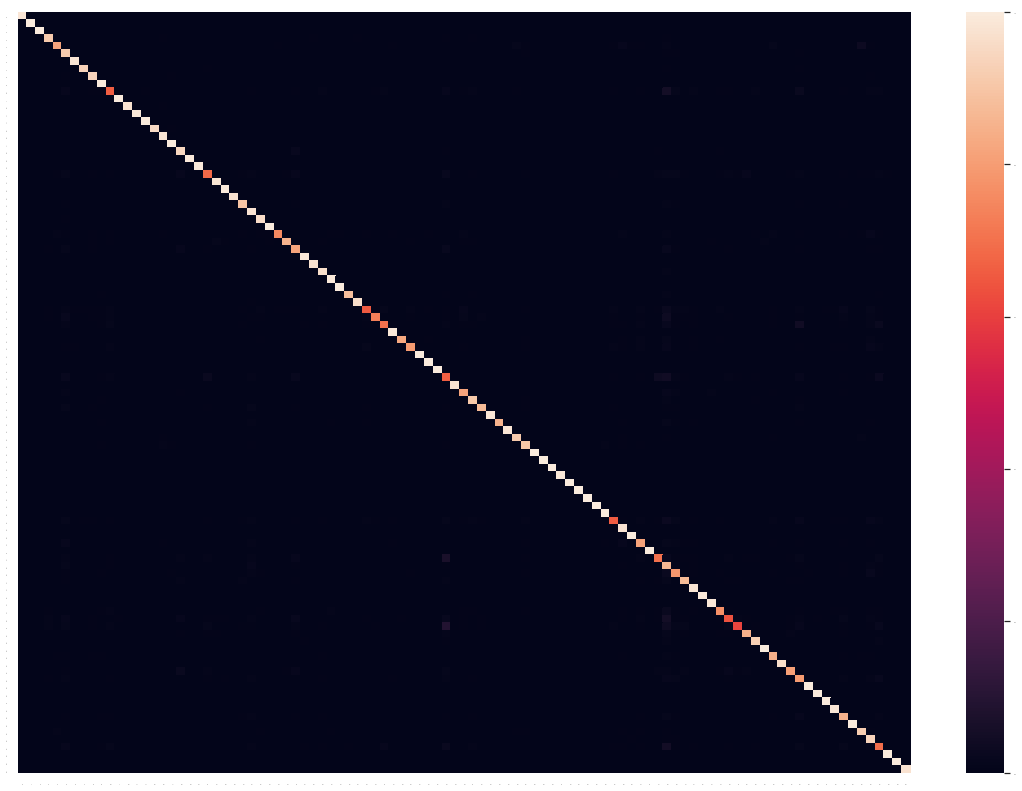

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, range(101),
                  range(101))
plt.figure(figsize = (20,14))
sn.set(font_scale=0.1)#for label size
sn.heatmap(df_cm, annot=False)# font size ,annot_kws={"size": 16}

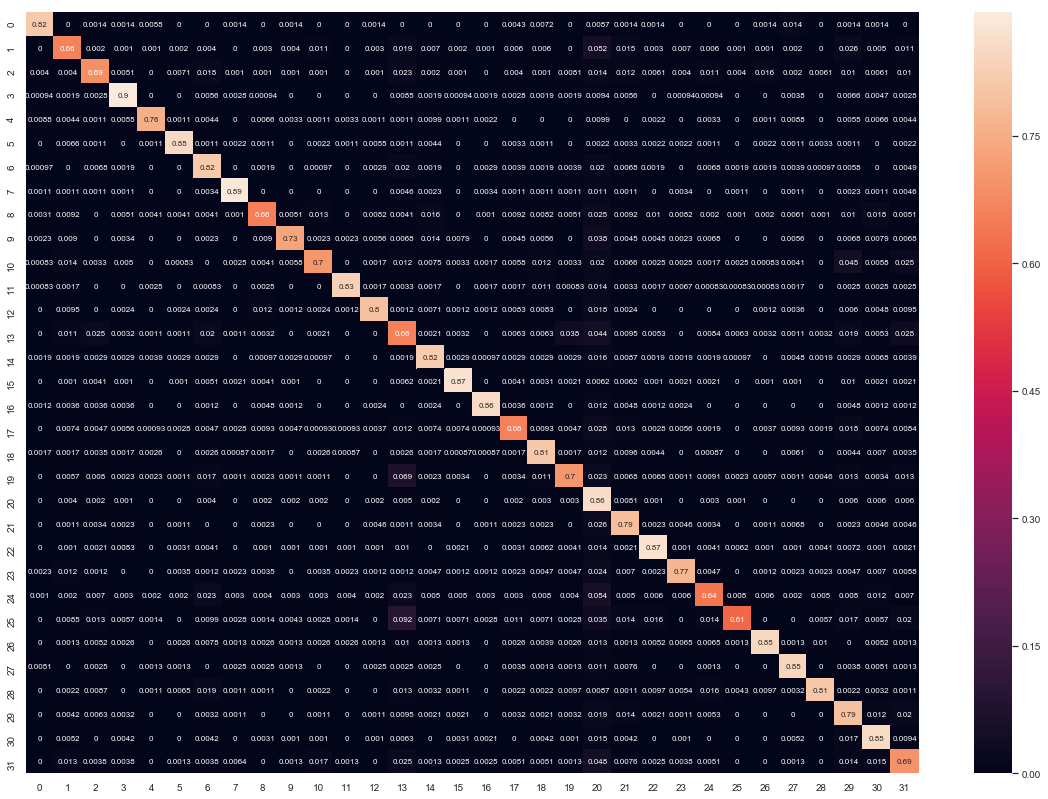

In [11]:
nsa = []
for i in range(101):
    if cnf_matrix[i,i]<0.9:
        nsa.append(i)
cnf_matrix_mini = cnf_matrix[nsa,:][:,nsa]
df_cm = pd.DataFrame(cnf_matrix_mini, range(len(nsa)),
                  range(len(nsa)))
plt.figure(figsize = (20,14))
np.set_printoptions(precision=3)
sn.set(font_scale=0.9)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

In [12]:
notsogood = []
for i, row in enumerate(cnf_matrix):
    for j, colj in enumerate(row):
        if colj > 0.05 and i!=j:
            print(cnf_matrix[i,j])
            notsogood.append([i,j])

0.05220883534136546
0.06939704209328783
0.05373134328358209
0.09219858156028368


In [13]:
for nsgi in notsogood:
    print(ucf_classes[nsgi[1]],"->",ucf_classes[nsgi[0]])

RockClimbingIndoor -> Biking
Kayaking -> Rafting
RockClimbingIndoor -> Skiing
Kayaking -> Skijet


Therefore we see that by taking a $70:30$ split for train and test we still get a class-wise accuracy of $91.6\%$ for the $101$ classes. Which is great!

Moreover the time reduces from $17.3$ seconds to $3.9$ seconds when queries reduces from $100,000$ to $30,000$.

### Time for $100$ queries over $100,000$ frames of $2048$ dimensionality:

In [10]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:100],k=3)

223 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time reduces to $0.22$ seconds for query of size $100$.

### Time for $10$ queries over $100,000$ frames of $2048$ dimensionality:

In [7]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:10],k=3)

198 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time reduces to $0.2$ seconds for query of size $10$.

### Time for $1$ queries over $100,000$ frames of $2048$ dimensionality:

In [8]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:1],k=3)

206 ms ± 5.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The time is still $0.2$ seconds for a query of size $1$.

### Speed Test with K = 10, 100, 200

In [11]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:1],k=10)

206 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:1],k=100)

195 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,\
                                                        test_vectors=X_test[:1],k=200)

214 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see the KNN similarity search scales well with the value of $K$. A single query on the $100,000$ datapoints of dimensionality $2048$ takes approximately $200$ ms each for $K = 3, 10, 100, 200$ 